# Charting PYLON Nested Query Analysis Results

When you perform analysis with PYLON you receive aggregated results from the API. 

We carry out much of work with PYLON in iPython as by its nature the results is a documented workflow that can be easily shared.

In this notebook we'll take a look at how you can use common Python libraries to chart analysis results from **nested queries**.

## Assumed knowledge

We won't explain all the basics of charting in this notebook. To get started with charting analysis results see [Charting PYLON Analysis Results](Charting PYLON Analysis Results.ipynb).

## Environment

To create this notebook we used:

* Python 2.7.6
* iPython 4.0.0
* pandas
* [DataSift client library](http://dev.datasift.com/tools/client-libraries)

The best way to install the above requirements is using [Anaconda](https://www.continuum.io/downloads). Anaconda provides a tested installation bundle including most popular Python packages.

## Charting nested query results

Firstly for the sake of this example we'll first parse an example API response for a nested query. This will give us a dictionary structure the same as we'd receive from the client library when using the API.

In [1]:
import json 

nested_api_result = '''{
    "unique_authors": 556400, 
    "analysis": {
        "analysis_type": "freqDist", 
        "redacted": false, 
        "results": [
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 124500, 
                            "key": "18-24", 
                            "interactions": 151900
                        }, 
                        {
                            "unique_authors": 124200, 
                            "key": "25-34", 
                            "interactions": 146200
                        }, 
                        {
                            "unique_authors": 76400, 
                            "key": "35-44", 
                            "interactions": 96000
                        }, 
                        {
                            "unique_authors": 43800, 
                            "key": "45-54", 
                            "interactions": 57400
                        }, 
                        {
                            "unique_authors": 19500, 
                            "key": "55-64", 
                            "interactions": 26400
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 404800, 
                "key": "male", 
                "interactions": 492000
            }, 
            {
                "child": {
                    "analysis_type": "freqDist", 
                    "redacted": false, 
                    "results": [
                        {
                            "unique_authors": 34300, 
                            "key": "25-34", 
                            "interactions": 43200
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "35-44", 
                            "interactions": 35600
                        }, 
                        {
                            "unique_authors": 31200, 
                            "key": "18-24", 
                            "interactions": 34800
                        }, 
                        {
                            "unique_authors": 21400, 
                            "key": "45-54", 
                            "interactions": 26400
                        }, 
                        {
                            "unique_authors": 12600, 
                            "key": "55-64", 
                            "interactions": 15500
                        }
                    ], 
                    "parameters": {
                        "threshold": 5, 
                        "target": "fb.author.age"
                    }
                }, 
                "unique_authors": 141400, 
                "key": "female", 
                "interactions": 164500
            }
        ], 
        "parameters": {
            "threshold": 2, 
            "target": "fb.author.gender"
        }
    }, 
    "interactions": 671300
}'''

nested_result = json.loads(nested_api_result)

As usual, you'll first need to check the analysis has not been redacted before attempting to plot a chart.

At this point you'll want to consider how you'd like to present your results. The example data represents a gender-age breakdown of an audience. In this case it makes sense to draw a chart for each gender.

In the example code below we first setup a subplots, one for each gender. Next we iterate through the child analysis results. Here there is 2, one for each gender indicated by the 'key' field. Finally we draw each subplot based on the data in the child result just like we did above for the frequency distribution analysis.

Notice that we sort the dataframe by its index before plotting to maintain the intuitive order of the age groups.

Populating the interactive namespace from numpy and matplotlib


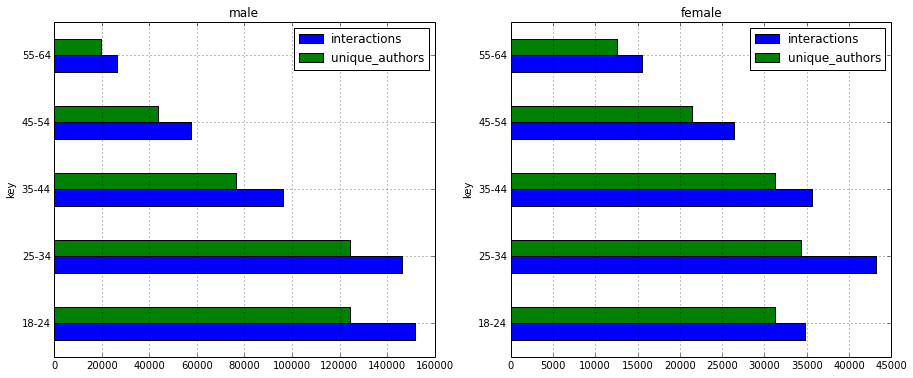

In [2]:
# This causes charts to be drawn inline
%pylab inline

# Import pandas for data manipulation
import pandas as pd

# Check result is not redacted
if not nested_result['analysis']['redacted']:

    # Set up subplots, one for each gender
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    
    # Iterate through genders, drawing a subplot for each
    for i, child in enumerate(nested_result['analysis']['results']):
        
        nested_df = pd.DataFrame.from_records(child['child']['results'],index='key')
        
        # Plot the chart, first sorting by the age groups in the index
        nested_df.sort_index().plot(kind='barh', ax=axes[i], title=child['key'])

## Charting results as a 'pyramid'

Another visualization approach is to draw results as a 'pyramid'. This makes particularly good sense when comparing two groups such as male and female. You can draw the charts back-to-back for a clear visual reading.

Instead of iterating the child results, in this example we:
* Combine the results for male and female into one dataframe
* Plot a chart for male and female, but reverse the female plot to create the pyramid shape
* Find the max X value to normalise the two charts for easier comparison

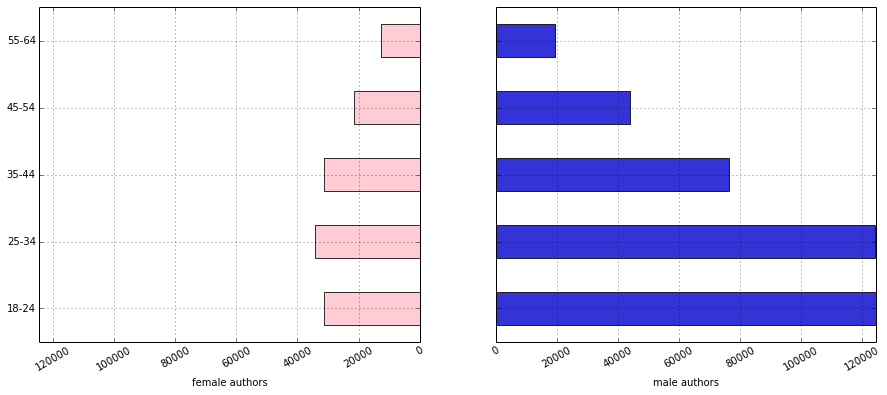

In [3]:
from matplotlib import gridspec

# Check result is not redacted
if not nested_result['analysis']['redacted']:

    # Build dataframe of results
    df_male = pd.DataFrame.from_records(
        nested_result['analysis']['results'][0]['child']['results'],index='key')
    
    df_female = pd.DataFrame.from_records(
        nested_result['analysis']['results'][1]['child']['results'],index='key')
    
    df_pyramid = pd.concat([df_male, df_female], axis=1, keys=['male','female'])
    
    # Create layout for subplots
    fig = plt.figure(figsize=(15,6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])
    axes=map(plt.subplot,gs)
    
    # Plot charts
    #  - Note that finding the max X value across results helps us normalize the charts, and
    #  plot the female chart in reverse to create the pyramid shape
    max_xlim=max(df_pyramid[('male', 'unique_authors')].max(),df_pyramid[('female', 'unique_authors')].max())
    
    female_subplot=df_pyramid[('female','unique_authors')].plot(kind='barh',ax=axes[0],color='pink',alpha=0.8)
    female_subplot.set_xlim([max_xlim,0]) # This line 'reverses' the bars on the chart
    
    male_subplot=df_pyramid[('male', 'unique_authors')].plot(kind='barh',ax=axes[1],color='mediumblue',alpha=0.8)
    male_subplot.set_xlim([0,max_xlim])
    
    # Tidy up axis labels for presentation
    axes[0].set_xlabel('female authors')
    axes[1].set_xlabel('male authors')
    axes[1].set_ylabel('')
    axes[1].set_yticklabels(['' for item in axes[1].get_yticklabels()]) 
    for i in (0,1):
        for j in axes[i].xaxis.get_major_ticks():
            j.label.set_rotation(30)

# What next?

Now you've learnt some further charting skills take a look at the other examples in this repository, such as:
* [Charting PYLON Baselined Analysis Results](Charting PYLON Baselined Analysis Results.ipynb)